In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('MyDrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at MyDrive


In [0]:
def get_class_index(c_name, classes):
  for i in range(len(classes)):
    name = classes[i].split(' ')[-1].strip()
    if name == c_name:
      return i

def center_crop(frame):
    frame = frame[8:120, 30:142, :]
    return np.array(frame).astype(np.uint8)

with open('hmdb_labels.txt', 'r') as f:
    classes = f.readlines()
    f.close()

**Previous Model Architecture**

In [0]:
import torch
import torch.nn as nn

class Prev_Mod(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Prev_Mod, self).__init__()

        '''
        Pretrained feature extractor
        '''
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))
        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)

        '''
        Trained Layer
        '''
        self.fc8 = nn.Linear(4096, num_classes)

        '''
        Xavier Initialization
        '''
        torch.nn.init.xavier_uniform_(self.fc8.weight)

        if pretrained:
            self.__load_pretrained_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)
        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        x = x.view(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)
        return logits

    def __load_pretrained_weights(self):
        corresp_name = {
                        "features.0.weight": "conv1.weight",
                        "features.0.bias": "conv1.bias",
                        "features.3.weight": "conv2.weight",
                        "features.3.bias": "conv2.bias",
                        "features.6.weight": "conv3a.weight",
                        "features.6.bias": "conv3a.bias",
                        "features.8.weight": "conv3b.weight",
                        "features.8.bias": "conv3b.bias",
                        "features.11.weight": "conv4a.weight",
                        "features.11.bias": "conv4a.bias",
                        "features.13.weight": "conv4b.weight",
                        "features.13.bias": "conv4b.bias",
                        "features.16.weight": "conv5a.weight",
                        "features.16.bias": "conv5a.bias",
                        "features.18.weight": "conv5b.weight",
                        "features.18.bias": "conv5b.bias",
                        "classifier.0.weight": "fc6.weight",
                        "classifier.0.bias": "fc6.bias",
                        "classifier.3.weight": "fc7.weight",
                        "classifier.3.bias": "fc7.bias",
                        }

        p_dict = torch.load('c3d-pretrained.pth')
        s_dict = self.state_dict()
        for name in p_dict:
            if name not in corresp_name:
                continue
            s_dict[corresp_name[name]] = p_dict[name]
        self.load_state_dict(s_dict)

**Current Model**


Pre-trained 3D resnet code taken from https://github.com/kenshohara/3D-ResNets-PyTorch

In [0]:
import math
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F


def get_inplanes():
    return [64, 128, 256, 512]

'''
3D conv layers
'''
def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)


def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)


'''
Resnet Block
'''
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

'''
Full 3D Resnet
'''

class ResNet(nn.Module):

    def __init__(self,
                 block,
                 layers,
                 block_inplanes,
                 n_input_channels=3,
                 conv1_t_size=7,
                 conv1_t_stride=1,
                 no_max_pool=False,
                 shortcut_type='B',
                 widen_factor=1.0,
                 n_classes=51):
        super().__init__()

        block_inplanes = [int(x * widen_factor) for x in block_inplanes]

        self.in_planes = block_inplanes[0]
        self.no_max_pool = no_max_pool

        self.conv1 = nn.Conv3d(n_input_channels,
                               self.in_planes,
                               kernel_size=(conv1_t_size, 7, 7),
                               stride=(conv1_t_stride, 2, 2),
                               padding=(conv1_t_size // 2, 3, 3),
                               bias=False)
        self.bn1 = nn.BatchNorm3d(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, block_inplanes[0], layers[0],
                                       shortcut_type)
        self.layer2 = self._make_layer(block,
                                       block_inplanes[1],
                                       layers[1],
                                       shortcut_type,
                                       stride=2)
        self.layer3 = self._make_layer(block,
                                       block_inplanes[2],
                                       layers[2],
                                       shortcut_type,
                                       stride=2)
        self.layer4 = self._make_layer(block,
                                       block_inplanes[3],
                                       layers[3],
                                       shortcut_type,
                                       stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(block_inplanes[3] * block.expansion, n_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _downsample_basic_block(self, x, planes, stride):
        out = F.avg_pool3d(x, kernel_size=1, stride=stride)
        zero_pads = torch.zeros(out.size(0), planes - out.size(1), out.size(2),
                                out.size(3), out.size(4))
        if isinstance(out.data, torch.cuda.FloatTensor):
            zero_pads = zero_pads.cuda()

        out = torch.cat([out.data, zero_pads], dim=1)

        return out

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            if shortcut_type == 'A':
                downsample = partial(self._downsample_basic_block,
                                     planes=planes * block.expansion,
                                     stride=stride)
            else:
                downsample = nn.Sequential(
                    conv1x1x1(self.in_planes, planes * block.expansion, stride),
                    nn.BatchNorm3d(planes * block.expansion))

        layers = []
        layers.append(
            block(in_planes=self.in_planes,
                  planes=planes,
                  stride=stride,
                  downsample=downsample))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        if not self.no_max_pool:
            x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def generate(model_depth, **kwargs):
    assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    if model_depth == 10:
        model = ResNet(BasicBlock, [1, 1, 1, 1], get_inplanes(), **kwargs)
    elif model_depth == 18:
        model = ResNet(BasicBlock, [2, 2, 2, 2], get_inplanes(), **kwargs)
    elif model_depth == 34:
        model = ResNet(BasicBlock, [3, 4, 6, 3], get_inplanes(), **kwargs)

    return model

In [0]:
# Action taken in the videos and paths to the trained models
action_name = 'climb_stairs'
model_path_prev = 'prev_model_c3d.pt'
model_path_curr = 'curr_model_r3d.pt'

The following function takes in the actual action from a video as well as the file paths to the trained model and video to be given to the model. The function also saves the time/label json and plot if specified as well as the time/label plot if specified. Additionally, the function now takes an argument to state whether we are using the previous or current model.

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from google.colab.patches import cv2_imshow

def get_vid_probs_and_json(action_name,model_path,video_path,save_fig_json=False,save_name_fig=None,save_name_json=None,prev=False):
    '''
    Load model
    '''
    if prev:
      model = Prev_Mod(num_classes=51,pretrained=False)
    else:
      model = generate(18)

    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()

    '''
    Get video
    '''
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    '''
    List for the timestamp/prob and list for the clips
    '''
    full_list = []
    clip = []

    '''
    Iterate through each frame in the video
    '''
    i = 0
    still_frames = True
    while still_frames:
        i+=1
        still_frames, frame = cap.read()
        if still_frames:
            if i > 15:
              # Only append if we are past the 16th frame as the previous are not used
              full_list.append([cap.get(cv2.CAP_PROP_POS_MSEC)/1000])
        else:
            break

        '''
        Adapted Preprocessing code
        '''
        resized = center_crop(cv2.resize(frame, (171, 128)))
        tmp = resized - np.array([[[90.0, 98.0, 102.0]]])
        clip.append(tmp)

        
        # Has to fit model shape so wait until we get 16 frames
        if len(clip) == 16:
          with torch.no_grad():
            inputs = np.array(clip).astype(np.float32)
            inputs = np.expand_dims(inputs, axis=0)
            inputs = np.transpose(inputs, (0, 4, 1, 2, 3))
            inputs = torch.from_numpy(inputs)
            inputs = torch.autograd.Variable(inputs, requires_grad=False).cuda()
            outputs = model.forward(inputs)

          probs = torch.nn.Softmax(dim=1)(outputs)

          class_index = get_class_index(action_name, classes)
          full_list[-1].append(probs[0][class_index].item())

          clip.pop(0)

    del full_list[-1]

    plt.xlabel('Time (seconds)')
    plt.ylabel('Prob of Given Action')
    plt.plot(np.array(full_list)[:,0],np.array(full_list)[:,1])
    if save_fig_json:
      plt.savefig(save_name_fig)

    full_json = {action_name: full_list}
    if save_fig_json:
        with open(save_name_json, 'w') as fp:
          json.dump(full_json, fp)

    return full_json


The first 3 videos show the current model performing similary well to the previous model on videos, however, the last 2 videos show where the current models improves on tough videos where the previous model seriously struggled.

**Videos Showing Consistently Strong Performance From Current Model**

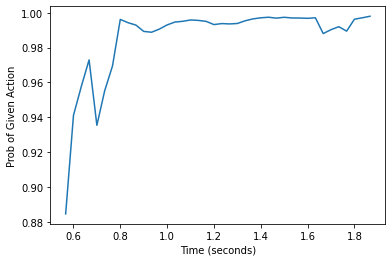

In [78]:
video_path = 'videos/climb_stairs/Piano_stairs__-_TheFunTheory_com_-_Rolighetsteorin_se_climb_stairs_f_nm_np2_ba_med_3.avi'
dl = get_vid_probs_and_json(action_name, model_path_curr, video_path,True,'fig1one','json1one')

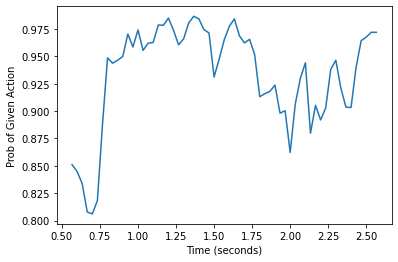

In [77]:
video_path = 'videos/climb_stairs/I_DO_NOT_Run_Up_Stairs_Like_A_GIRL_climb_stairs_l_cm_np1_ba_med_4.avi'
dl = get_vid_probs_and_json(action_name, model_path_curr, video_path,True,'fig1two','json1two')

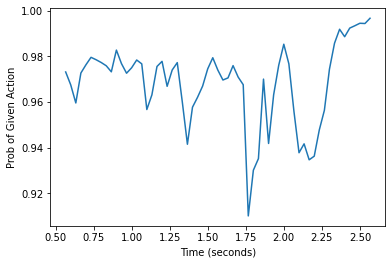

In [72]:
video_path = 'videos/climb_stairs/H_I_I_T__Swamis_stairs_with_Max_Wettstein_featuring_Donna_Wettstein_climb_stairs_f_cm_np3_ba_med_3.avi'
dl = get_vid_probs_and_json(action_name, model_path_curr, video_path,True,'fig1three','json1three')

**Improvements Where the Model Previously Struggled**

**Previous Model**

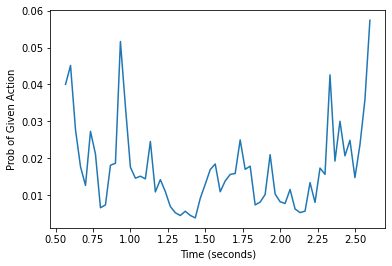

In [73]:
video_path = 'videos/climb_stairs/Intense_Cardio_Session-_Stairs_climb_stairs_f_cm_np1_ba_med_2.avi'
dl = get_vid_probs_and_json(action_name, model_path_prev, video_path,True,'fig2prev_one','json2prev_one',prev=True)

**Current Model**

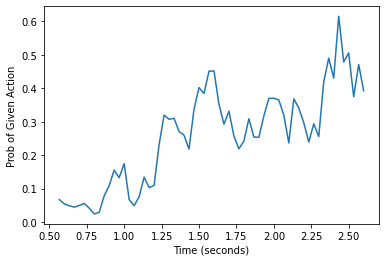

In [74]:
video_path = 'videos/climb_stairs/Intense_Cardio_Session-_Stairs_climb_stairs_f_cm_np1_ba_med_2.avi'
dl = get_vid_probs_and_json(action_name, model_path_curr, video_path,True,'fig2curr_one','json2curr_one')

**Previous Model**

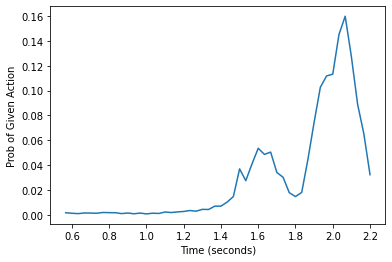

In [75]:
video_path = 'videos/climb_stairs/AgentCodyBanks_climb_stairs_f_cm_np1_fr_med_9.avi'
dl = get_vid_probs_and_json(action_name, model_path_prev, video_path,True,'fig2prev_two','json2prev_two',prev=True)

**Current Model**

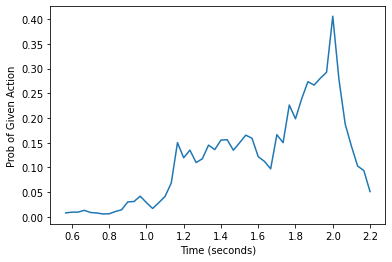

In [76]:
video_path = 'videos/climb_stairs/AgentCodyBanks_climb_stairs_f_cm_np1_fr_med_9.avi'
dl = get_vid_probs_and_json(action_name, model_path_curr, video_path,True,'fig2curr_two','json2curr_two')